# Python Assignment 4

## 1. Mandelbrot Set

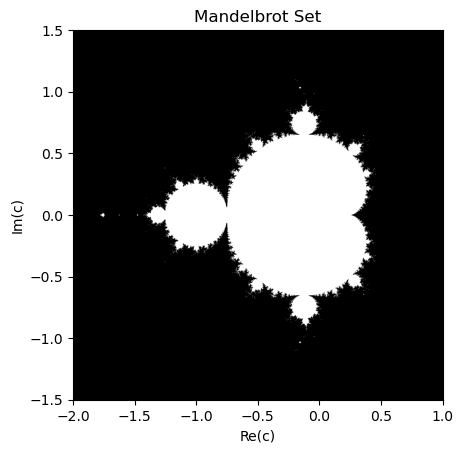

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter, threshold):

    #grid of complex numbers across [xmin, xmax] x [ymin, ymax]
    x, y = np.mgrid[xmin:xmax:width*1j, ymin:ymax:height*1j]
    #complex numbers
    c = x + 1j*y
    #initialize z
    z = np.zeros_like(c)

    #mask to see which points are in the set
    mask = np.ones(c.shape, dtype = bool)

    for i in range (max_iter):
        #keep only diverged points
        z[mask] = z[mask] ** 2 + c[mask]
        #update mask
        mask[np.abs(z) > threshold] = False

    #only return the points in the set through the mask
    return mask


def main():
    #set by the assignment
    width = 1000
    height = 1000
    xmin, xmax = -2.0, 1.0
    ymin, ymax = -1.5, 1.5
    max_iter = 50
    threshold = 100

    mandelbrot_mask = mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter, threshold)

#from assignment
    plt.imshow(mandelbrot_mask.T, extent=[-2, 1, -1.5, 1.5])
    plt.gray()
    #axis and title
    plt.title("Mandelbrot Set")
    plt.xlabel("Re(c)")
    plt.ylabel("Im(c)")
    plt.savefig("mandelbrot.png", dpi=300)
    plt.show()

#run the above code
if __name__ == "__main__":
    main()

## 2. Markov Chain

In [2]:
import numpy as np

def create_random_transition_matrix(n):
    #random values [0,1]
    P = np.random.rand(n, n)
    #normalize each row sum to 1
    P /= P.sum(axis=1, keepdims=True)
    return P

def create_random_distribution(n):
    p = np.random.rand(n)
    #normalize sum(p) = 1
    p /= p.sum()
    return p

def apply_transition(P, p, steps=50):
    #transition rule
    PT = P.T
    for _ in range(steps):
        p = np.dot(PT, p)
    return p

def compute_stationary_distribution(P):
    eigvals, eigvecs = np.linalg.eig(P.T)
    #eigenvalue closest to 1
    idx = np.argmin(np.abs(eigvals - 1))
    v = np.real(eigvecs[:, idx])
    #rid of negative components
    v = np.abs(v)
    #normalize
    v /= v.sum()
    return v

def main():
    #set by assignment
    n = 5

    #random 5x5 matrix
    P = create_random_transition_matrix(n)
    print("Transition matrix (P):\n", P, "\n")

    #probability vector
    p = create_random_distribution(n)
    print("Initial probability vector (p):\n", p, "\n")

    #transition rule done 50 times
    p50 = apply_transition(P, p, steps=50)
    print("Probability vector after 50 transitions:\n", p50, "\n")

    #stationary distribution
    stationary = compute_stationary_distribution(P)
    print("Stationary distribution (v):\n", stationary, "\n")

    #compute difference
    diff = np.abs(p50 - stationary)
    print("Component-wise absolute difference:\n", diff, "\n")
    print("Maximum difference:", np.max(diff))

    #check their error
    if np.allclose(p50, stationary, atol=1e-5):
        print("\np50 and stationary distribution match within 10^-5.")
    else:
        print("\np50 and stationary distribution do not match within 10^-5.")

#run above code
if __name__ == "__main__":
    main()

Transition matrix (P):
 [[0.17394928 0.42288708 0.0809595  0.15779278 0.16441137]
 [0.24715064 0.0676712  0.25826685 0.16808449 0.25882682]
 [0.26181259 0.21702749 0.23373498 0.20382511 0.08359983]
 [0.24528887 0.14201742 0.20751624 0.07198826 0.33318921]
 [0.24620479 0.03159072 0.47316319 0.22043252 0.02860879]] 

Initial probability vector (p):
 [0.14578331 0.23899634 0.08950435 0.17888445 0.34683155] 

Probability vector after 50 transitions:
 [0.23311742 0.19248168 0.23882592 0.16699791 0.16857707] 

Stationary distribution (v):
 [0.23311742 0.19248168 0.23882592 0.16699791 0.16857707] 

Component-wise absolute difference:
 [1.94289029e-16 1.94289029e-16 2.22044605e-16 8.32667268e-17
 8.32667268e-17] 

Maximum difference: 2.220446049250313e-16

p50 and stationary distribution match within 10^-5.


## 3. Taylor Series Approximation

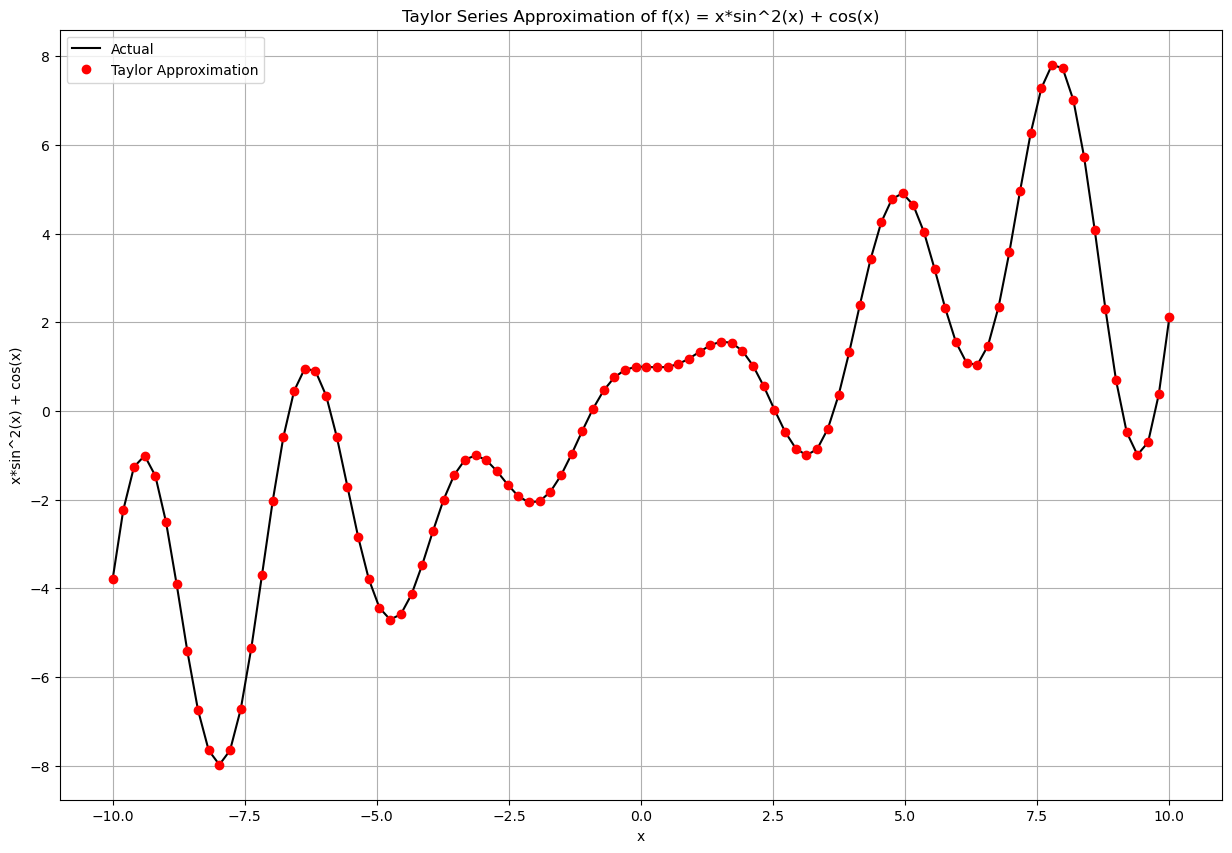

   degree   total_error  time_seconds
0      50  4.949573e+01      0.083147
1      60  1.754212e-03      0.098139
2      70  1.275624e-07      0.113161
3      80  1.319471e-07      0.127711
4      90  1.319471e-07      0.156168
5     100  1.319471e-07      0.162579


In [8]:
import numpy as np
import sympy as sp
import pandas as pd
import time
import matplotlib.pyplot as plt

def taylor_approximation(func, start, end, degree, c):
    #use x the variable not the character
    x = sp.symbols('x')

    #derivatives up to the nth one
    derivatives = [func.diff(x, n) for n in range(degree + 1)]

    #l00 evenly spaced x-values
    x_vals = np.linspace(start, end, 100)
    #initialize array of zeroes
    approx_vals = np.zeros_like(x_vals, dtype=float)

    for n in range(degree + 1):
        #fixed around c
        nth_term = (derivatives[n].subs(x, c) / sp.factorial(n)) * (x_vals - c) ** n #nth term of the series
        approx_vals += np.array(nth_term, dtype=float) #add up the series

    return x_vals, approx_vals


def factorial_analysis(func, start, end, c, initial_degree, final_degree, degree_step):
    x = sp.symbols('x')
    #done for numeric evaluation
    f_lambdified = sp.lambdify(x, func, modules='numpy')
    x_vals = np.linspace(start, end, 100)
    #compute the true values at the above x points
    true_vals = f_lambdified(x_vals)

    #initialize list
    records = []

    #loop through different taylor series degrees
    for degree in range(initial_degree, final_degree + 1, degree_step):
        #record computation time
        start_time = time.time()
        #do actual taylor approx
        _, approx_vals = taylor_approximation(func, start, end, degree, c)
        #compute the time elapsed
        elapsed = time.time() - start_time

        total_error = np.sum(np.abs(true_vals - approx_vals))

        #store results
        records.append({
            'degree': degree,
            'total_error': total_error,
            'time_seconds': elapsed
        })

    #convert to a pandas df
    df = pd.DataFrame(records)
    #save as a csv as asked in the assignment
    df.to_csv("taylor_values.csv", index=False)

    return df


def main():
    x = sp.symbols('x')
    #function definted by the assignment
    func = x * sp.sin(x)**2 + sp.cos(x)

    #also from the assignment
    start, end = -10, 10
    degree = 99
    c = 0

    #do the taylor approx
    x_vals, approx_vals = taylor_approximation(func, start, end, degree, c)

    #compare
    f_lambdified = sp.lambdify(x, func, modules='numpy')
    true_vals = f_lambdified(x_vals)

    #plot the function and taylor approx
    plt.figure(figsize=(15, 10))
    #black line similar to the assignment
    plt.plot(x_vals, true_vals, label="Actual", color = "black")
    #uses red dots similar to the assignment
    plt.plot(x_vals, approx_vals, "ro", label=f"Taylor Approximation")
    plt.xlabel("x")
    plt.ylabel("x*sin^2(x) + cos(x)")
    plt.title("Taylor Series Approximation of f(x) = x*sin^2(x) + cos(x)")
    plt.legend()
    plt.grid(True)
    plt.savefig("taylor_plot.png", dpi=300)
    plt.show()

    #do for multiple degrees
    df = factorial_analysis(func, start, end, c,
                            initial_degree=50,
                            final_degree=100,
                            degree_step=10)

    print(df)

#run above code
if __name__ == "__main__":
    main()